In [1]:
import xarray as xr
import pandas as pd
data_temp = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Temp\*.nc", parallel=False)
data_tmax = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmax\*.nc", parallel=False)
data_tmin = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_tmin\*.nc", parallel=False)
data_rain = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Rain\*.nc", parallel=False)
data_hurs = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Humidity\*.nc", parallel=False)
data_sun = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Sun\*.nc", parallel=False)
data_frost = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Frost\*.nc", parallel=False)
data_psl = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_psl\*.nc", parallel=False)
data_wind = xr.open_mfdataset(r"C:\Users\iarla\OneDrive\Documents\MSc_Project\HadUK_data\12km_Month_Wind\*.nc", parallel=False)

In [2]:
import numpy as np

rain = np.array(data_rain['rainfall'])
hurs = np.array(data_hurs['hurs'])
temp = np.array(data_temp['tas'])
temp_max = np.array(data_tmax['tasmax'])
temp_min = np.array(data_tmin['tasmin'])
sun = np.array(data_sun['sun'])
frost = np.array(data_frost['groundfrost'])
psl = np.array(data_psl['psl'])
wind = np.array(data_wind['sfcWind'])

min_length = len(wind)
rain = rain[:min_length]
hurs = hurs[:min_length]
temp = temp[:min_length]
temp_max = temp_max[:min_length]
temp_min = temp_min[:min_length]
sun = sun[:min_length]
frost = frost[:min_length]
wind = wind[:min_length]
psl = psl[:min_length]

In [3]:
import torch 

land_mask = ~np.isnan(temp)
land_mask_torch = torch.from_numpy(land_mask.astype(bool)) 

print(temp.shape)
print(land_mask.shape)

(648, 112, 82)
(648, 112, 82)


In [4]:
from skimage import measure

# Connected components labeling
labels = measure.label(land_mask)
biggest_component_label = np.argmax(np.bincount(labels.flat)[1:]) + 1  

# Isolate the biggest component
main_landmass_mask = (labels == biggest_component_label) 

# Get indices for bounding box
nonzero_indices = main_landmass_mask.nonzero()
min_row = np.min(nonzero_indices[1])
max_row = np.max(nonzero_indices[1])
min_col = np.min(nonzero_indices[2])
max_col = np.max(nonzero_indices[2])

In [5]:
rain = rain[:, min_row:max_row + 1, min_col:max_col + 1]
hurs = hurs[:, min_row:max_row + 1, min_col:max_col + 1]
temp = temp[:, min_row:max_row + 1, min_col:max_col + 1]
temp_max = temp_max[:, min_row:max_row + 1, min_col:max_col + 1]
temp_min = temp_min[:, min_row:max_row + 1, min_col:max_col + 1]
sun = sun[:, min_row:max_row + 1, min_col:max_col + 1] 
frost = frost[:, min_row:max_row + 1, min_col:max_col + 1] 
psl = psl[:, min_row:max_row + 1, min_col:max_col + 1] 
wind = wind[:, min_row:max_row + 1, min_col:max_col + 1] 
land_mask = land_mask[:, min_row:max_row + 1, min_col:max_col + 1]

In [6]:
nan_counts = np.count_nonzero(np.isnan(rain), axis=0)  # Counts across time

valid_grid_cell_mask = nan_counts == 0
valid_cell_indices = np.where(valid_grid_cell_mask)

# Your arrays from the previous output:
row_indices = valid_cell_indices[0]
col_indices = valid_cell_indices[1]

unique_rows, row_counts = np.unique(row_indices, return_counts=True)
unique_cols, col_counts = np.unique(col_indices, return_counts=True)

In [7]:
valid_row_indices = valid_cell_indices[0]  # Extract row indices
valid_col_indices = valid_cell_indices[1]  # Extract column indices

valid_rain_data = rain[:, valid_row_indices, valid_col_indices]
valid_temp_data = temp[:, valid_row_indices, valid_col_indices]
valid_wind_data = wind[:, valid_row_indices, valid_col_indices]
valid_hurs_data = hurs[:, valid_row_indices, valid_col_indices]
valid_psl_data = psl[:, valid_row_indices, valid_col_indices]
valid_frost_data = frost[:, valid_row_indices, valid_col_indices]
valid_sun_data = sun[:, valid_row_indices, valid_col_indices]
valid_tmax_data = temp_max[:, valid_row_indices, valid_col_indices]
valid_tmin_data = temp_min[:, valid_row_indices, valid_col_indices]

In [8]:
valid_rain_data = valid_rain_data[:,:1600].reshape(648, 64, 25)
valid_temp_data = valid_temp_data[:,:1600].reshape(648, 64, 25)
valid_wind_data = valid_wind_data[:,:1600].reshape(648, 64, 25)
valid_hurs_data = valid_hurs_data[:,:1600].reshape(648, 64, 25)
valid_psl_data = valid_psl_data[:,:1600].reshape(648, 64, 25)
valid_sun_data = valid_sun_data[:,:1600].reshape(648, 64, 25)
valid_frost_data = valid_frost_data[:,:1600].reshape(648, 64, 25)
valid_tmax_data = valid_tmax_data[:,:1600].reshape(648, 64, 25)
valid_tmin_data = valid_tmin_data[:,:1600].reshape(648, 64, 25)

In [9]:
nan_count_temp = np.isnan(valid_temp_data).sum()
nan_count_tmax = np.isnan(valid_tmax_data).sum()
nan_count_tmin = np.isnan(valid_tmin_data).sum()
nan_count_wind = np.isnan(valid_wind_data).sum()

print('Number of NaN values in Temp:', nan_count_temp)
print('Number of NaN values in Tmax:', nan_count_tmax)
print('Number of NaN values in Tmin:', nan_count_tmin)
print('Number of NaN values in Wind:', nan_count_wind)


def fill_nan_with_mean(data):
    col_mean = np.nanmean(data, axis=0)  # Calculate mean per column
    inds = np.where(np.isnan(data))
    data[inds] = np.take(col_mean, inds[1])  # Replace NaNs with mean
    return data

temp_filled = fill_nan_with_mean(valid_temp_data.copy())  
tmax_filled = fill_nan_with_mean(valid_tmax_data.copy())
tmin_filled = fill_nan_with_mean(valid_tmin_data.copy())
wind_filled = fill_nan_with_mean(valid_wind_data.copy())

nan_count_temp = np.isnan(temp_filled).sum()
nan_count_tmax = np.isnan(tmax_filled).sum()
nan_count_tmin = np.isnan(tmin_filled).sum()
nan_count_wind = np.isnan(wind_filled).sum()

print('Number of NaN values in Temp:', nan_count_temp)
print('Number of NaN values in Tmax:', nan_count_tmax)
print('Number of NaN values in Tmin:', nan_count_tmin)
print('Number of NaN values in Tmin:', nan_count_tmin)

Number of NaN values in Temp: 123
Number of NaN values in Tmax: 108
Number of NaN values in Tmin: 123
Number of NaN values in Wind: 167
Number of NaN values in Temp: 0
Number of NaN values in Tmax: 0
Number of NaN values in Tmin: 0
Number of NaN values in Tmin: 0


In [10]:
rain = np.array(valid_rain_data)
temp = np.array(temp_filled)
hurs = np.array(valid_hurs_data)
frost = np.array(valid_frost_data)
sun = np.array(valid_sun_data)
wind = np.array(wind_filled)
psl = np.array(valid_psl_data)
temp_max = np.array(tmax_filled)
temp_min = np.array(tmin_filled)


rain_last = rain[625:]
temp_last = temp[625:]
frost_last = frost[625:]
sun_last = sun[625:]
wind_last = wind[625:]
hurs_last = hurs[625:]
psl_last = psl[625:]
temp_max_last = temp_max[625:]
temp_min_last = temp_min[625:]

rain = rain[:647]
temp = temp[:647]
frost = frost[:647]
sun = sun[:647]
wind = wind[:647]
hurs = hurs[:647]
psl = psl[:647]
temp_max = temp_max[:647]
temp_min = temp_min[:647]



In [11]:
print('Rain', rain.shape)
print('Temp', temp.shape)
print('Hurs', hurs.shape)
print('Frost', frost.shape)
print('Sun', sun.shape)
print('Wind', wind.shape)
print('Psl', psl.shape)
print('Temp_max', temp_max.shape)
print('Temp_min', temp_min.shape)

print('Rain_last', rain_last.shape)
print('Temp_last', temp_last.shape)
print('Hurs_last', hurs_last.shape)
print('Frost_last', frost_last.shape)
print('Sun_last', sun_last.shape)
print('Wind_last', wind_last.shape)
print('Psl_last', psl_last.shape)
print('Temp_max_last', temp_max_last.shape)
print('Temp_min_last', temp_min_last.shape)

Rain (647, 64, 25)
Temp (647, 64, 25)
Hurs (647, 64, 25)
Frost (647, 64, 25)
Sun (647, 64, 25)
Wind (647, 64, 25)
Psl (647, 64, 25)
Temp_max (647, 64, 25)
Temp_min (647, 64, 25)
Rain_last (23, 64, 25)
Temp_last (23, 64, 25)
Hurs_last (23, 64, 25)
Frost_last (23, 64, 25)
Sun_last (23, 64, 25)
Wind_last (23, 64, 25)
Psl_last (23, 64, 25)
Temp_max_last (23, 64, 25)
Temp_min_last (23, 64, 25)


In [12]:
rain = torch.from_numpy(rain)
temp = torch.from_numpy(temp)
hurs = torch.from_numpy(hurs)
frost = torch.from_numpy(frost)
sun = torch.from_numpy(sun)
wind = torch.from_numpy(wind)
psl = torch.from_numpy(psl)
tmax = torch.from_numpy(temp_max)
tmin = torch.from_numpy(temp_min)

In [13]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# List of tensors
tensors = [rain, temp, hurs, frost, sun, wind, psl, tmax, tmin]

# Normalize each tensor
for i in range(len(tensors)):
    # Convert tensor to numpy array
    array = tensors[i].numpy()

    # Get the original shape of the array
    original_shape = array.shape

    # Reshape the array to 2D
    array = array.reshape(-1, 1)

    # Fit the scaler on the data
    scaler.fit(array)

    # Transform the data
    array = scaler.transform(array)

    # Reshape the array back to its original shape
    array = array.reshape(original_shape)

    # Convert the numpy array back to tensor
    tensors[i] = torch.from_numpy(array)

# tensors now contains the normalized tensors
rain_tensor, temp_tensor, hurs_tensor, frost_tensor, sun_tensor, wind_tensor, psl_tensor, tmax_tensor, tmin_tensor = tensors

In [14]:
rain_tensor.shape

torch.Size([647, 64, 25])

In [15]:
# Stack along the channels dimension (dim=1)
stacked_tensor = torch.stack(tensors, dim=1) 
print(stacked_tensor.shape)


torch.Size([647, 9, 64, 25])


In [31]:
import torch
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=9, out_channels=16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.fc1 = nn.Linear(32 * 14 * 4, 64*25)  # Adjusted this line
        
    def forward(self, x):
        x = x.float()
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 14 * 4)  
        x = self.fc1(x)
        return x.view(-1, 64, 25)  





In [33]:
forecast_horizon = 1
targets = temp_tensor[forecast_horizon:, :, :]

print("Original temperature tensor shape:", temp_tensor.shape)
print("Targets tensor shape:", targets.shape)

Original temperature tensor shape: torch.Size([647, 64, 25])
Targets tensor shape: torch.Size([646, 64, 25])


In [35]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

stacked_tensor = stacked_tensor[:-forecast_horizon, :, :]

# Split the stacked tensor into training, validation, and testing sets
X_train, X_val_test, y_train, y_val_test = train_test_split(stacked_tensor, targets, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

print("Training set shapes:", X_train.shape, y_train.shape)
print("Validation set shapes:", X_val.shape, y_val.shape)
print("Testing set shapes:", X_test.shape, y_test.shape)

# Create DataLoader objects
batch_size = 32

train_dataset = TensorDataset(X_train.clone().detach(), y_train.clone().detach())
val_dataset = TensorDataset(X_val.clone().detach(), y_val.clone().detach())
test_dataset = TensorDataset(X_test.clone().detach(), y_test.clone().detach())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

Training set shapes: torch.Size([516, 9, 64, 25]) torch.Size([516, 64, 25])
Validation set shapes: torch.Size([65, 9, 64, 25]) torch.Size([65, 64, 25])
Testing set shapes: torch.Size([65, 9, 64, 25]) torch.Size([65, 64, 25])


Epoch 1/20, Train Loss: 0.3452, Val Loss: 0.3127, Train MAE: 0.4531, Val MAE: 0.4609, Train R^2: 0.6464, Val R^2: 0.7538
Epoch 2/20, Train Loss: 0.1673, Val Loss: 0.2479, Train MAE: 0.3214, Val MAE: 0.4055, Train R^2: 0.8286, Val R^2: 0.8048
Epoch 3/20, Train Loss: 0.1352, Val Loss: 0.2006, Train MAE: 0.2909, Val MAE: 0.3637, Train R^2: 0.8616, Val R^2: 0.8421
Epoch 4/20, Train Loss: 0.1244, Val Loss: 0.1948, Train MAE: 0.2777, Val MAE: 0.3618, Train R^2: 0.8725, Val R^2: 0.8466
Epoch 5/20, Train Loss: 0.1108, Val Loss: 0.1825, Train MAE: 0.2618, Val MAE: 0.3458, Train R^2: 0.8865, Val R^2: 0.8564
Epoch 6/20, Train Loss: 0.1069, Val Loss: 0.2051, Train MAE: 0.2568, Val MAE: 0.3758, Train R^2: 0.8905, Val R^2: 0.8385
Epoch 7/20, Train Loss: 0.1089, Val Loss: 0.1952, Train MAE: 0.2591, Val MAE: 0.3609, Train R^2: 0.8885, Val R^2: 0.8463
Epoch 8/20, Train Loss: 0.1092, Val Loss: 0.2036, Train MAE: 0.2603, Val MAE: 0.3685, Train R^2: 0.8882, Val R^2: 0.8397
Epoch 9/20, Train Loss: 0.1059, 

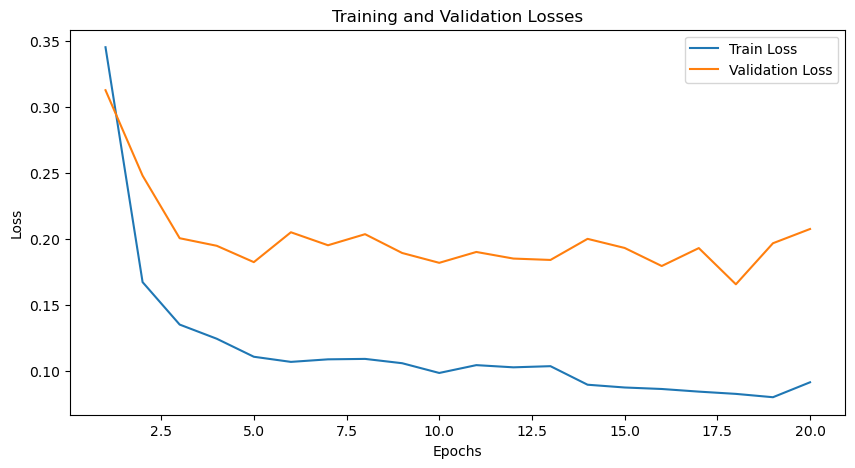

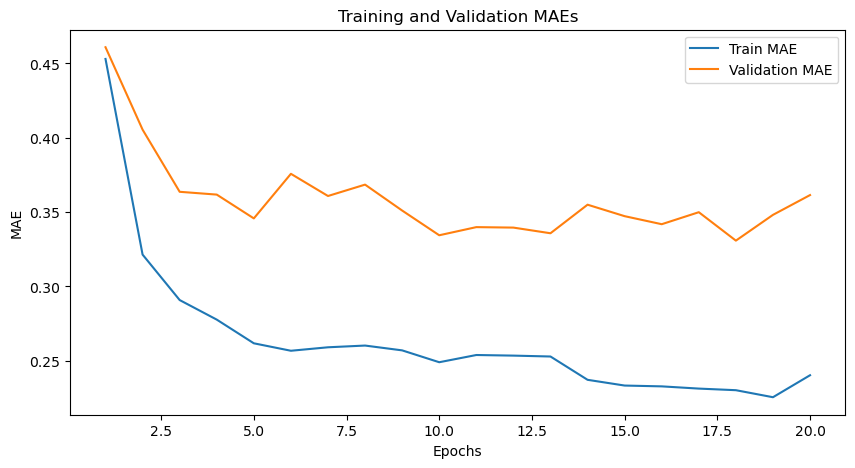

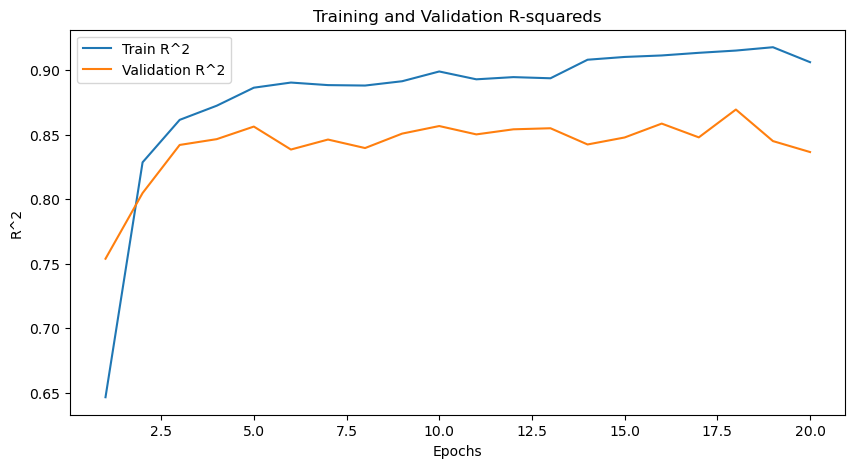

In [36]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Initialize the model, optimizer, and loss function
model = CNNModel()
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

# Lists to store metrics
train_losses = []
val_losses = []
train_maes = []
val_maes = []
train_r_squareds = []
val_r_squareds = []

# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_mae = 0.0
    y_true_train = []
    y_pred_train = []   
    for inputs, targets in train_loader:
        inputs, targets = inputs.float(), targets.float()  
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        
        # Calculate MAE
        train_mae += torch.abs(outputs - targets).mean().item() * inputs.size(0)
        
        # Store predictions and true values for R-squared calculation
        y_true_train.extend(targets.detach().numpy())
        y_pred_train.extend(outputs.detach().numpy())

    train_loss /= len(train_loader.dataset)
    train_mae /= len(train_loader.dataset)

    y_true_train = np.array(y_true_train)
    y_pred_train = np.array(y_pred_train)
    ss_res_train = np.sum((y_true_train - y_pred_train) ** 2)
    ss_tot_train = np.sum((y_true_train - np.mean(y_true_train)) ** 2)
    train_r_squared = 1 - (ss_res_train / ss_tot_train)

    # Validation loop
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    y_true_val = []
    y_pred_val = []

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.float(), targets.float()  
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            
            # Calculate MAE
            val_mae += torch.abs(outputs - targets).mean().item() * inputs.size(0)
            
            # Store predictions and true values for R-squared calculation
            y_true_val.extend(targets.detach().numpy())
            y_pred_val.extend(outputs.detach().numpy())

    val_loss /= len(val_loader.dataset)
    val_mae /= len(val_loader.dataset)

    y_true_val = np.array(y_true_val)
    y_pred_val = np.array(y_pred_val)
    ss_res_val = np.sum((y_true_val - y_pred_val) ** 2)
    ss_tot_val = np.sum((y_true_val - np.mean(y_true_val)) ** 2)
    val_r_squared = 1 - (ss_res_val / ss_tot_val)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train MAE: {train_mae:.4f}, Val MAE: {val_mae:.4f}, Train R^2: {train_r_squared:.4f}, Val R^2: {val_r_squared:.4f}')

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_maes.append(train_mae)
    val_maes.append(val_mae)
    train_r_squareds.append(train_r_squared)
    val_r_squareds.append(val_r_squared)


# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_maes, label='Train MAE')
plt.plot(range(1, num_epochs+1), val_maes, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAEs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_r_squareds, label='Train R^2')
plt.plot(range(1, num_epochs+1), val_r_squareds, label='Validation R^2')
plt.xlabel('Epochs')
plt.ylabel('R^2')
plt.title('Training and Validation R-squareds')
plt.legend()
plt.show()

In [37]:
# Testing
model.eval()
test_loss = 0.0
test_mae = 0.0
y_true_test = []
y_pred_test = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.float(), targets.float()  
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item() * inputs.size(0)
        
        # Calculate MAE
        test_mae += torch.abs(outputs - targets).mean().item() * inputs.size(0)
        
        # Store predictions and true values for R-squared calculation
        y_true_test.extend(targets.detach().numpy())
        y_pred_test.extend(outputs.detach().numpy())

test_loss /= len(test_loader.dataset)
test_mae /= len(test_loader.dataset)

y_true_test = np.array(y_true_test)
y_pred_test = np.array(y_pred_test)
ss_res_test = np.sum((y_true_test - y_pred_test) ** 2)
ss_tot_test = np.sum((y_true_test - np.mean(y_true_test)) ** 2)
test_r_squared = 1 - (ss_res_test / ss_tot_test)

print(f'Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}, Test R^2: {test_r_squared:.4f}')

Test Loss: 0.1400, Test MAE: 0.2901, Test R^2: 0.8473


In [38]:
last_data = stacked_tensor[645, :, :]

# Add an extra dimension for batch size
last_data = last_data[np.newaxis, :, :]

# Switch model to evaluation mode
model.eval()

# Make sure no gradients are being tracked
with torch.no_grad():
    # Use the model to predict the next time step
    next_step = model(last_data)

# Print the predicted next time step
print(f'Predicted next time step: {next_step}')

Predicted next time step: tensor([[[ 0.1434,  0.2047,  0.0491,  ..., -0.4222, -0.3772, -0.1419],
         [-0.0416, -0.0013, -0.2445,  ..., -0.3917, -0.3244, -0.3010],
         [-0.2126, -0.1899, -0.1219,  ..., -0.2519, -0.2936, -0.1862],
         ...,
         [-1.0131, -1.1576, -1.1872,  ..., -0.5166, -0.4540, -0.5103],
         [-0.7639, -0.9832, -0.8324,  ..., -0.6073, -0.9206, -0.9116],
         [-0.8703, -0.8357, -1.0112,  ..., -0.6054, -0.6209, -0.6501]]])


In [39]:
next_step.shape

torch.Size([1, 64, 25])

In [40]:
forecasts = next_step

forecasts_2d = forecasts.reshape(-1, 1)

# Reshape the data to 2D array
data_2d = temp.reshape(-1, 1)

# Fit the scaler on the original data
scaler.fit(data_2d)

# Now you can use it to revert the normalization
reverted_forecasts_2d = scaler.inverse_transform(forecasts_2d)

# Reshape the reverted data back to its original shape
reverted_forecasts = reverted_forecasts_2d.reshape(forecasts.shape)

In [41]:
temp_last_1 = temp_last[21, :, :]
print(temp_last_1.shape)
print(reverted_forecasts.shape)

(64, 25)
(1, 64, 25)


In [42]:
# Assuming X_temp and future_predictions are NumPy arrays
comparison_df = pd.DataFrame({
    'Actual_Temp': temp_last_1.flatten(),  
    'Predicted_Temp': reverted_forecasts.flatten()
})

# Display the DataFrame
print(comparison_df)

      Actual_Temp  Predicted_Temp
0        8.734846        8.760358
1        8.956846        9.040310
2        8.306932        8.329686
3        8.118835        8.105151
4        8.345772        8.557253
...           ...             ...
1595     5.296701        5.180872
1596     5.613230        5.793053
1597     5.232188        5.341347
1598     5.287242        5.270349
1599     5.088702        5.137229

[1600 rows x 2 columns]


In [43]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

r2 = r2_score(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'])
print(f"R-squared: {r2}")


mae = mean_absolute_error(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'])
print(f"Mean Absolute Error: {mae}")


mse = mean_squared_error(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'])
print(f"Mean Squared Error: {mse}")

R-squared: 0.7579695451475135
Mean Absolute Error: 0.4358093933255324
Mean Squared Error: 0.2710375822678919


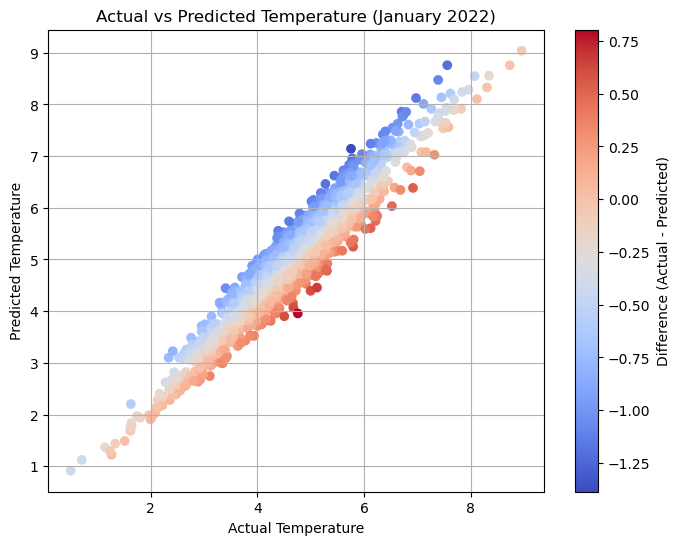

In [44]:
# Calculate the difference between actual and predicted temperature
comparison_df['Difference'] = comparison_df['Actual_Temp'] - comparison_df['Predicted_Temp']

# Create a scatter plot with a colormap representing the difference
plt.figure(figsize=(8, 6))
plt.scatter(comparison_df['Actual_Temp'], comparison_df['Predicted_Temp'], c=comparison_df['Difference'], cmap='coolwarm')

# Add labels and title
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Actual vs Predicted Temperature (January 2022)')

# Add colorbar
plt.colorbar(label='Difference (Actual - Predicted)')

# Show the plot
plt.grid(True)
plt.show()